In [1]:
%matplotlib inline

import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer

import utils

sns.set_context("notebook", font_scale=1.5)
plt.rcParams['figure.figsize'] = (17, 5)

In [3]:
tracks = utils.load('C:/Users/night/Documents/09/school/actual-masters/git/masters/models/data/fma/fma_metadata/tracks.csv')
genres = utils.load('C:/Users/night/Documents/09/school/actual-masters/git/masters/models/data/fma/fma_metadata/genres.csv')
features = utils.load('C:/Users/night/Documents/09/school/actual-masters/git/masters/models/data/fma/fma_metadata/features.csv')
echonest = utils.load('C:/Users/night/Documents/09/school/actual-masters/git/masters/models/data/fma/fma_metadata/echonest.csv')

np.testing.assert_array_equal(features.index, tracks.index)
assert echonest.index.isin(tracks.index).all()

tracks.shape, genres.shape, features.shape, echonest.shape

((106574, 52), (163, 4), (106574, 518), (13129, 249))

In [18]:
print('{} tracks, {} genres'.format(
    len(tracks),
    sum(genres['#tracks'] > 0)))

print()

for subset in tracks['set', 'subset'].unique():
    indicator = tracks['set', 'subset'] <= subset
    print('{:6} {:6} tracks'.format(
        subset, sum(indicator)))
    
print()
          
splits = ['training', 'validation', 'test']
subsets = ['small', 'medium', 'large']
print('subset    #train    #val   #test  val_ratio test_ratio')
for subset in subsets:
    counts = [sum((tracks['set', 'split'] == split) & (tracks['set', 'subset'] <= subset)) for split in splits]
    ratios_val = (counts[0] / counts[1])
    ratios_test = (counts[0] / counts[2])
    print('{:8s} {:7d} {:7d} {:7d} {:8.2f} {:9.2f}'.format(subset, *counts, ratios_val, ratios_test))

106574 tracks, 161 genres

small    8000 tracks
medium  25000 tracks
large  106574 tracks

subset    #train    #val   #test  val_ratio test_ratio
small       6400     800     800     8.00      8.00
medium     19922    2505    2573     7.95      7.74
large      84353   10958   11263     7.70      7.49


In [19]:
for subset in ['small', 'medium']:
    subset = tracks['set', 'subset'] <= subset

    d = genres.reset_index().set_index('title')
    d = d.loc[tracks.loc[subset, ('track', 'genre_top')].unique()]

    for split in SPLITS:
        b = tracks['set', 'split'] == split
        d['#' + split] = tracks.loc[subset & b, ('track', 'genre_top')].value_counts()

    d['val_ratio'] = d['#training'] / d['#validation']
    d['test_ratio'] = d['#training'] / d['#test']

    ipd.display(d.sort_values('#training', ascending=False))

,genre_id,#tracks,parent,top_level,#training,#validation,#test,val_ratio,test_ratio
title,,,,,,,,,
Hip-Hop,21,8389,0,21,800,100,100,8.0,8.0
Pop,10,13845,0,10,800,100,100,8.0,8.0
Folk,17,12706,0,17,800,100,100,8.0,8.0
Experimental,38,38154,0,38,800,100,100,8.0,8.0
Rock,12,32923,0,12,800,100,100,8.0,8.0
International,2,5271,0,2,800,100,100,8.0,8.0
Electronic,15,34413,0,15,800,100,100,8.0,8.0
Instrumental,1235,14938,0,1235,800,100,100,8.0,8.0


,genre_id,#tracks,parent,top_level,#training,#validation,#test,val_ratio,test_ratio
title,,,,,,,,,
Rock,12,32923,0,12,5681,711,711,7.990155,7.990155
Electronic,15,34413,0,15,5050,632,632,7.990506,7.990506
Experimental,38,38154,0,38,1801,225,225,8.004444,8.004444
Hip-Hop,21,8389,0,21,1761,220,220,8.004545,8.004545
Folk,17,12706,0,17,1215,152,152,7.993421,7.993421
Instrumental,1235,14938,0,1235,1045,131,174,7.977099,6.005747
Pop,10,13845,0,10,945,122,119,7.745902,7.941176
International,2,5271,0,2,814,102,102,7.980392,7.980392
Classical,5,4106,0,5,495,62,62,7.983871,7.983871


In [20]:
d = pd.DataFrame(index=genres.index, columns=SPLITS)
for genre in genres.index:
    b = tracks['track', 'genres_all'].map(lambda genres: genre in genres)
    d.loc[genre] = tracks.loc[b, ('set', 'split')].value_counts()
d['val_ratio'] = d['training'] / d['validation']
d['test_ratio'] = d['training'] / d['test']
d.sort_values('training', ascending=False, inplace=True)
ipd.display(d.head(10))
ipd.display(d.tail(10))

,training,validation,test,val_ratio,test_ratio
genre_id,,,,,
38,29691,4511,3952,6.581911,7.512905
15,27313,3463,3637,7.887092,7.509761
12,25819,3690,3414,6.997019,7.562683
1235,11785,1474,1679,7.995251,7.019059
10,11001,1376,1468,7.994913,7.493869
17,9960,1245,1501,8.0,6.635576
25,7366,974,921,7.562628,7.997828
1,6865,970,858,7.07732,8.001166
21,6426,961,1002,6.686785,6.413174


,training,validation,test,val_ratio,test_ratio
genre_id,,,,,
444,10,7,8,1.428571,1.25
374,9.0,NaN,NaN,NaN,NaN
808,8.0,4.0,NaN,2.0,NaN
465,4,4,10,1.0,0.4
173,3.0,NaN,1.0,NaN,3.0
174,2,1,14,2.0,0.142857
377,1.0,NaN,NaN,NaN,NaN
493,1,1,2,1.0,0.5
175,NaN,NaN,NaN,NaN,NaN


In [21]:
a = set(tracks['track', 'genre_top'].unique().dropna())
b = set(genres.loc[genres['top_level'].unique(), 'title'].values)
assert a == b

print('{} top-level genres'.format(len(a)))
genres[genres['parent'] == 0].sort_values('#tracks', ascending=False)

16 top-level genres


,#tracks,parent,title,top_level
genre_id,,,,
38,38154,0,Experimental,38
15,34413,0,Electronic,15
12,32923,0,Rock,12
1235,14938,0,Instrumental,1235
10,13845,0,Pop,10
17,12706,0,Folk,17
21,8389,0,Hip-Hop,21
2,5271,0,International,2
4,4126,0,Jazz,4


genres
max: 25 per track: from 0 to 25 tags
genres_all
max: 31 per track: from 0 to 31 tags
#tracks without genre: 2231


C:\Users\night\AppData\Local\Temp/ipykernel_37164/1936176633.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['0'] + ['{}0k'.format(i) for i in range(1, 6)])


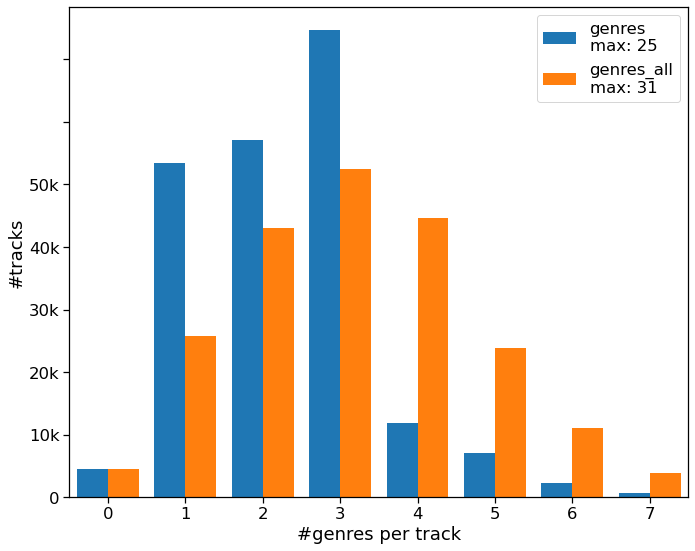

In [32]:
# Genres per track.
labels = ['genres', 'genres_all']  #, 'genres_top']
d = [tracks['track', label].map(len) for label in labels]
labels = ['{}\nmax: {}'.format(label, d1.max()) for label, d1 in zip(labels, d)]

for l, d1 in zip(labels, d):
    print('{} per track: from {} to {} tags'.format(l, d1.min(), d1.max()))
print('#tracks without genre: {}'.format((tracks['track', 'genres'].map(len) == 0).sum()))

MAX = 9
fig, ax = plt.subplots(figsize=(10, 8))
ax.hist(d, bins=np.arange(MAX)-0.5, label=labels)
ax.set_xlabel('#genres per track')
ax.set_ylabel('#tracks')
ax.set_xlim(-0.5, MAX-1.5)
ax.set_xticks(range(MAX-1))
ax.set_yticklabels(['0'] + ['{}0k'.format(i) for i in range(1, 6)])
ax.legend(loc='upper right')
fig.tight_layout()
# fig.savefig('figures/genres_per_track.pdf')

C:\Users\night\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(1, 38154)

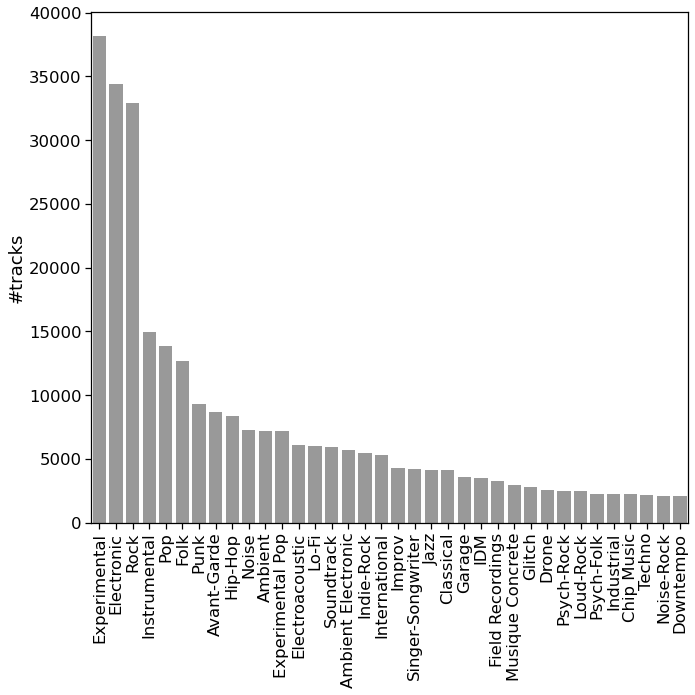

In [31]:
# Number of tracks per genre (full).
d = genres[genres['#tracks'] > 2000].sort_values('#tracks', ascending=False)  # Poster: 5000
plt.figure(figsize=(10, 10))  # Poster: (7, 4)
p = sns.barplot('title', '#tracks', data=d, color='k', alpha=0.4)
p.set_xlabel('')
p.set_ylabel('#tracks')
plt.xticks(rotation=90)
plt.tight_layout()
# plt.savefig('figures/genre_distribution.pdf')

genres.loc[genres['#tracks'] > 0, '#tracks'].min(), genres['#tracks'].max()

Rock                   7103
Electronic             6314
Experimental           2251
Hip-Hop                2201
Folk                   1519
Instrumental           1350
Pop                    1186
International          1018
Classical               619
Old-Time / Historic     510
Jazz                    384
Country                 178
Soul-RnB                154
Spoken                  118
Blues                    74
Easy Listening           21
Name: (track, genre_top), dtype: int64

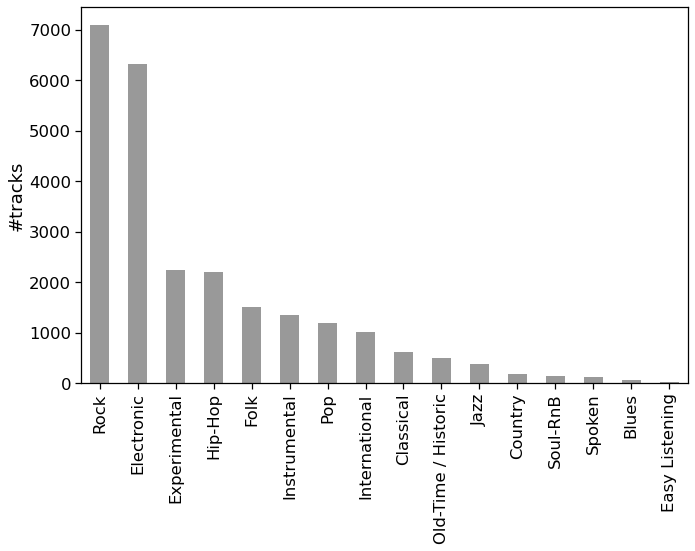

In [34]:
# Number of tracks per top-level genre (medium).
d = tracks[tracks['set', 'subset'] <= 'medium']
d = d['track', 'genre_top'].value_counts()
plt.figure(figsize=(10, 8))  # Poster: (7, 4)
d.plot.bar(color='k', alpha=0.4)
plt.ylabel('#tracks')
plt.xlabel('')
plt.tight_layout()
# plt.savefig('figures/genre_top_distribution.pdf')

d

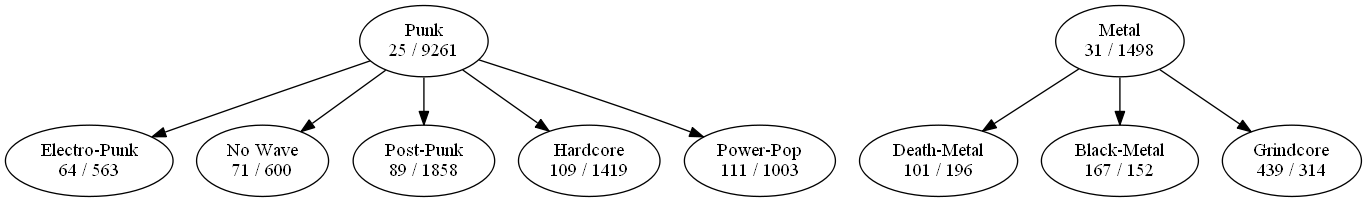

In [35]:
g = utils.Genres(genres)
graph = g.create_tree([25, 31], 1)
ipd.Image(graph.create_png())

In [36]:
graph = g.create_tree(14)
# graph.write_pdf('figures/genre_hierarchy.pdf');

roots = g.find_roots()
print('{} roots'.format(len(roots)))
graph = g.create_tree(roots)
# graph.write_pdf('figures/genre_hierarchy.pdf');

16 roots
